한국 어선:


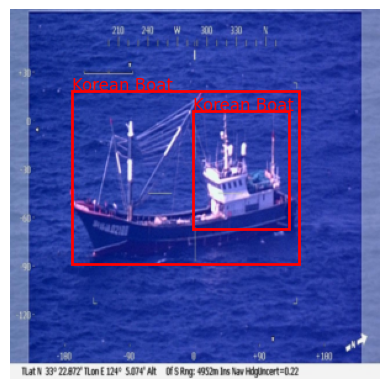

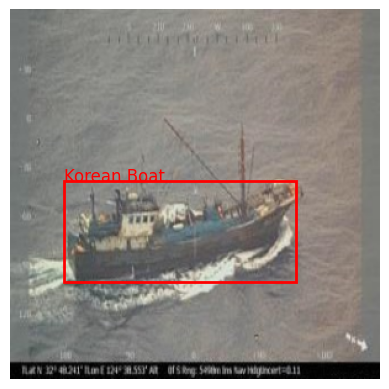

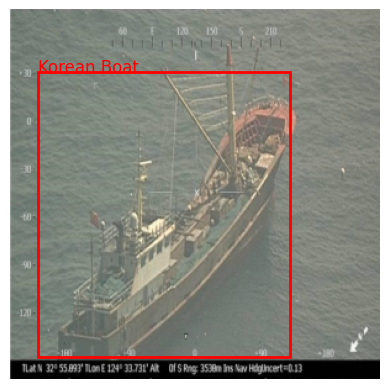

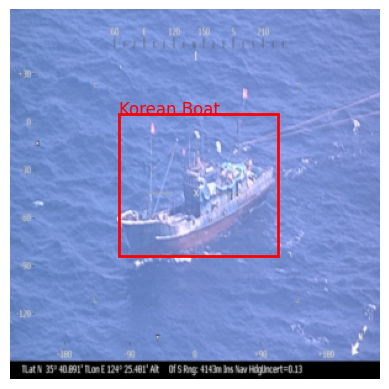

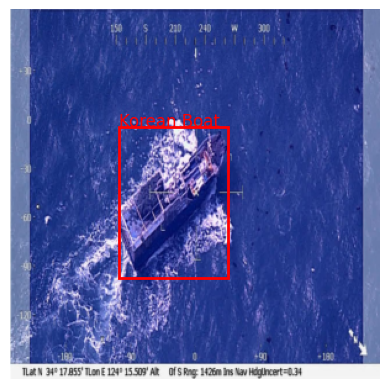

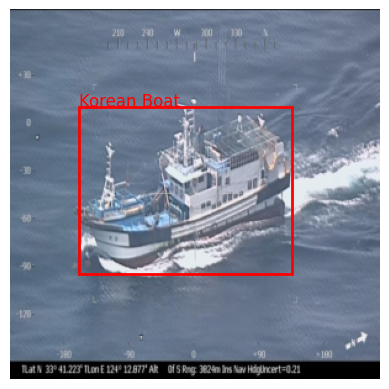

중국 어선:


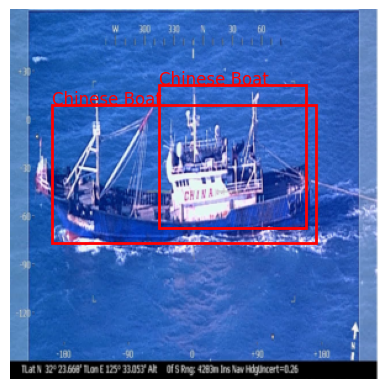

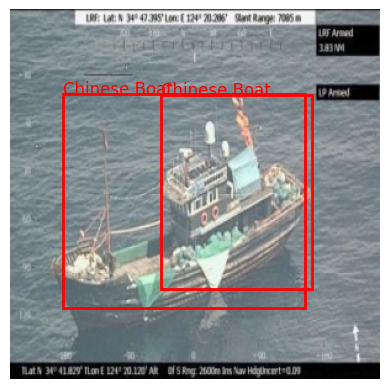

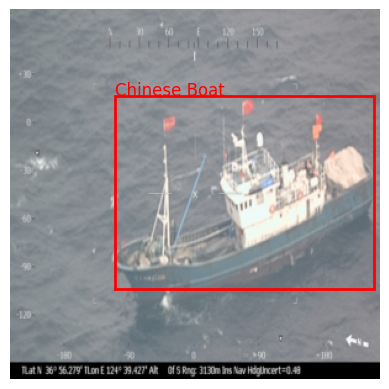

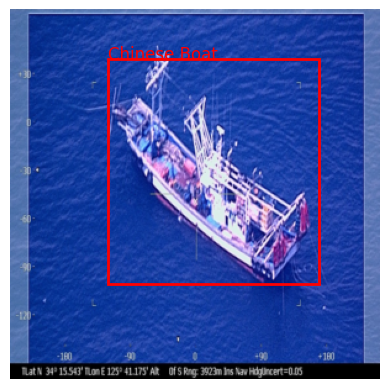

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt

# 사용할 장치 설정(CPU 또는 GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 사용자 정의 데이터셋 클래스
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, boxes, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.boxes = boxes  # 바운딩 박스 좌표
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # 이미지 열기 및 RGB로 변환
        
        label = self.labels[idx]
        box = self.boxes[idx]

        if self.transform:
            image = self.transform(image)

        # 바운딩 박스를 텐서로 변환
        box = torch.tensor(box, dtype=torch.float32)  # shape: [1, 4]
        
        # shape가 [1, 4]일 경우 squeeze를 사용하여 [4]로 변환
        if box.dim() == 2 and box.shape[0] == 1:
            box = box.squeeze(0)  # [1, 4] -> [4]

        # 타겟 구성 (박스와 레이블)
        target = {
            'boxes': box.unsqueeze(0),  # N=1로 맞춰주기 위해 다시 차원 추가
            'labels': torch.tensor([label], dtype=torch.int64)  # 우리나라 어선(0), 중국 어선(1) 구분
        }

        return image, target

def get_transform():
    transforms = []
    # 이미지를 모델 입력 크기에 맞게 변환
    transforms.append(torchvision.transforms.Resize((300, 300)))
    transforms.append(torchvision.transforms.ToTensor())
    
    return torchvision.transforms.Compose(transforms)
    

# 1. 이미지 경로, 레이블, 바운딩 박스 설정
image_paths = [
    "C:/Users/Admin/Desktop/새 닭/madek/1.jpg",
    "C:/Users/Admin/Desktop/새 닭/madek/2.jpg",
    "C:/Users/Admin/Desktop/새 닭/madek/3.jpg",
    "C:/Users/Admin/Desktop/새 닭/madek/4.jpg",
    "C:/Users/Admin/Desktop/새 닭/madek/11.jpg",
    "C:/Users/Admin/Desktop/새 닭/madek/12.jpg",
    "C:/Users/Admin/Desktop/새 닭/madec/5.jpg",
    "C:/Users/Admin/Desktop/새 닭/madec/6.jpg",
    "C:/Users/Admin/Desktop/새 닭/madec/7.jpg",
    "C:/Users/Admin/Desktop/새 닭/madec/8.jpg",
    "C:/Users/Admin/Desktop/새 닭/madec/9.jpg",
    "C:/Users/Admin/Desktop/새 닭/madec/10.jpg"
]

# 레이블 설정 (국내 어선=0, 중국 어선=1)
labels = [0] * 6 + [1] * 6  # 앞 6개는 국내 어선, 뒤 6개는 중국 어선으로 설정

# 간단한 바운딩 박스 좌표 설정 (예시로 모든 이미지를 동일한 크기의 박스로 설정)
boxes = [
    [[50, 50, 250, 250]],  # [xmin, ymin, xmax, ymax] 좌표
    [[60, 60, 260, 260]],
    [[70, 70, 270, 270]],
    [[80, 80, 280, 280]],
    [[90, 90, 290, 290]],
    [[100, 100, 300, 300]],
    [[110, 110, 310, 310]],
    [[120, 120, 320, 320]],
    [[130, 130, 330, 330]],
    [[140, 140, 340, 340]],
    [[150, 150, 350, 350]],
    [[160, 160, 360, 360]],
]

# 데이터셋 생성
transform = get_transform()
dataset = CustomImageDataset(image_paths, labels, boxes, transform=transform)

# 데이터 로더 준비
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# 미리 학습된 SSD 모델 로드
model = ssdlite320_mobilenet_v3_large(pretrained=True)

# 모델을 평가 모드로 설정
model.eval()
model.to(device)

# COCO 데이터셋의 클래스 인덱스
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 
    'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 
    'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 
    'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 
    'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 
    'toothbrush'
]

# 'boat' 클래스 인덱스
BOAT_CLASS_INDEX = COCO_INSTANCE_CATEGORY_NAMES.index('boat')

# '국내 어선'과 '중국 어선'에 맞는 레이블 생성
label_mapping = {0: 'Korean Boat', 1: 'Chinese Boat'}

def filter_boat_predictions(predictions, label, threshold=0.4):
    """
    예측된 객체 중 'boat' 클래스만 필터링하고, 라벨에 따라 국내/중국 어선으로 구분.
    """
    boat_predictions = {
        'boxes': [],
        'labels': [],
        'scores': []
    }
    for i in range(len(predictions['labels'])):
        pred_label = predictions['labels'][i].item()
        score = predictions['scores'][i].item()
        if pred_label == BOAT_CLASS_INDEX and score > threshold:  # 'boat' 클래스 필터링
            boat_predictions['boxes'].append(predictions['boxes'][i])
            boat_predictions['labels'].append(torch.tensor(label))  # 주어진 레이블(국내 또는 중국 어선)로 설정
            boat_predictions['scores'].append(predictions['scores'][i])

    # 리스트를 다시 텐서로 변환
    boat_predictions['boxes'] = torch.stack(boat_predictions['boxes']) if boat_predictions['boxes'] else torch.tensor([])
    boat_predictions['labels'] = torch.stack(boat_predictions['labels']) if boat_predictions['labels'] else torch.tensor([])
    boat_predictions['scores'] = torch.stack(boat_predictions['scores']) if boat_predictions['scores'] else torch.tensor([])

    return boat_predictions

def visualize_boat_predictions(label_type, filtered_predictions):
    """이미지 예측 결과를 보여주는 함수 (국내/중국 어선 구분)."""
    print(f"{label_type}:")
    for prediction in filtered_predictions:
        image, target = prediction
        plt.imshow(transforms.functional.to_pil_image(image))
        for box, label in zip(target["boxes"], target["labels"]):
            plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, edgecolor='red', linewidth=2))
            plt.text(box[0], box[1], f'{label_mapping[label.item()]}', color='red', fontsize=12)
        plt.axis('off')
        plt.show()



# '한국 어선'과 '중국 어선'을 각각의 그룹으로 나눠서 시각화
korean_boats = []
chinese_boats = []

for i in range(len(dataset)):
    image, target = dataset[i]
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(image)[0]  # 첫 번째 이미지에 대한 예측

    # 'boat'만 필터링된 예측 결과
    filtered_prediction = filter_boat_predictions(prediction, target['labels'].item(), threshold=0.3)

    # 예측 결과가 존재할 경우, 각각의 어선 그룹에 추가
    if len(filtered_prediction["boxes"]) > 0:
        if target['labels'].item() == 0:
            korean_boats.append((image.squeeze(0), filtered_prediction))
        else:
            chinese_boats.append((image.squeeze(0), filtered_prediction))

# '한국 어선' 시각화
visualize_boat_predictions('한국 어선', korean_boats)

# '중국 어선' 시각화
visualize_boat_predictions('중국 어선', chinese_boats)


In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torch.utils.data import DataLoader, Dataset
from torchvision.models import mobilenet_v3_large
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt

# 사용할 장치 설정(CPU 또는 GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 사용자 정의 데이터셋 클래스 (한국 어선과 중국 어선 구분을 위한)
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, boxes, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.boxes = boxes  # 바운딩 박스 좌표
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # 이미지 열기 및 RGB로 변환
        
        label = self.labels[idx]
        box = self.boxes[idx]

        if self.transform:
            image = self.transform(image)

        box = torch.tensor(box, dtype=torch.float32)
        if box.dim() == 2 and box.shape[0] == 1:
            box = box.squeeze(0)

        target = {
            'boxes': box.unsqueeze(0),
            'labels': torch.tensor([label], dtype=torch.int64)
        }

        return image, target

# 전처리
def get_transform():
    transforms_list = [torchvision.transforms.Resize((300, 300)), torchvision.transforms.ToTensor()]
    return torchvision.transforms.Compose(transforms_list)

# 한국/중국 어선 구분을 위한 MobileNetV3 분류기
class BoatClassifier(nn.Module):
    def __init__(self, num_classes=2):  # 한국 어선, 중국 어선 2개 클래스
        super(BoatClassifier, self).__init__()
        self.model = mobilenet_v3_large(pretrained=True)
        self.model.classifier[3] = nn.Linear(self.model.classifier[3].in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# 데이터셋 경로 및 레이블 설정
image_paths = [
    "C:/Users/Admin/Desktop/새 닭/madek/1.jpg",
    "C:/Users/Admin/Desktop/새 닭/madek/2.jpg",
    "C:/Users/Admin/Desktop/새 닭/madek/3.jpg",
    "C:/Users/Admin/Desktop/새 닭/madek/4.jpg",
    "C:/Users/Admin/Desktop/새 닭/madek/11.jpg",
    "C:/Users/Admin/Desktop/새 닭/madek/12.jpg",
    "C:/Users/Admin/Desktop/새 닭/madec/5.jpg",
    "C:/Users/Admin/Desktop/새 닭/madec/6.jpg",
    "C:/Users/Admin/Desktop/새 닭/madec/7.jpg",
    "C:/Users/Admin/Desktop/새 닭/madec/8.jpg",
    "C:/Users/Admin/Desktop/새 닭/madec/9.jpg",
    "C:/Users/Admin/Desktop/새 닭/madec/10.jpg",
   
]

# 레이블 설정 (0: 한국 어선, 1: 중국 어선)
labels = [0] * 6 + [1] * 6

# 바운딩 박스 좌표 설정
boxes = [
    [[50, 50, 250, 250]],
    [[60, 60, 260, 260]],
    [[70, 70, 270, 270]],
    [[80, 80, 280, 280]],
    [[90, 90, 290, 290]],
    [[100, 100, 300, 300]],
    [[110, 110, 310, 310]],
    [[120, 120, 320, 320]],
    [[130, 130, 330, 330]],
    [[140, 140, 340, 340]],
    [[150, 150, 350, 350]],
    [[160, 160, 360, 360]],
]

# 데이터셋 생성
transform = get_transform()
dataset = CustomImageDataset(image_paths, labels, boxes, transform=transform)

# 데이터 로더 준비
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# 미리 학습된 SSD 모델 로드 (보트 탐지를 위해)
detection_model = ssdlite320_mobilenet_v3_large(pretrained=True)
detection_model.eval()
detection_model.to(device)

# 보트 분류기 모델 (한국/중국 어선 구분을 위해)
classifier = BoatClassifier(num_classes=2)
classifier.to(device)

# 분류기의 손실 함수 및 최적화기 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

# 학습 함수
def train_classifier(num_epochs=20):
    classifier.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, targets in data_loader:
            images = images.to(device)

            # 타겟 레이블을 1D로 변환 (배치 차원을 제거하지 않도록 조정)
            labels = targets['labels'].to(device)

            # 만약 배치가 1개일 경우, squeeze로 차원을 제거하면 안 됨
            if labels.dim() > 1 and labels.shape[0] == 1:
                labels = labels.squeeze(0)

            # 분류기 출력
            outputs = classifier(images)

            # 손실 계산
            loss = criterion(outputs, labels)

            # 역전파 및 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # 정확도 계산
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total  # 에포크당 정확도 계산
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(data_loader):.4f}, Accuracy: {accuracy:.4f}")

# 학습 실행
train_classifier(num_epochs=10)

# 학습 후 하나의 이미지에 대해 예측 수행
def classify_boat(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = classifier(image)
        _, predicted = torch.max(outputs, 1)
        class_label = "한국 어선" if predicted.item() == 0 else "중국 어선"
        print(f"분류 결과: {class_label}")

# 테스트 이미지 분류
test_image_path = 
classify_boat(test_image_path)


IndexError: list index out of range

In [23]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torch.utils.data import DataLoader, Dataset
from torchvision.models import mobilenet_v3_large
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt

# 사용할 장치 설정(CPU 또는 GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 사용자 정의 데이터셋 클래스 (한국 어선과 중국 어선 구분을 위한)
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, boxes, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.boxes = boxes  # 바운딩 박스 좌표
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # 이미지 열기 및 RGB로 변환
        
        label = self.labels[idx]
        box = self.boxes[idx]

        if self.transform:
            image = self.transform(image)

        box = torch.tensor(box, dtype=torch.float32)
        if box.dim() == 2 and box.shape[0] == 1:
            box = box.squeeze(0)

        target = {
            'boxes': box.unsqueeze(0),
            'labels': torch.tensor([label], dtype=torch.int64)
        }

        return image, target

# 전처리
def get_transform():
    transforms_list = [torchvision.transforms.Resize((300, 300)), torchvision.transforms.ToTensor()]
    return torchvision.transforms.Compose(transforms_list)

# 한국/중국 어선 구분을 위한 MobileNetV3 분류기
class BoatClassifier(nn.Module):
    def __init__(self, num_classes=2):  # 한국 어선, 중국 어선 2개 클래스
        super(BoatClassifier, self).__init__()
        self.model = mobilenet_v3_large(pretrained=True)
        self.model.classifier[3] = nn.Linear(self.model.classifier[3].in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# 데이터셋 경로 및 레이블 설정
image_paths = [
    "C:/Users/Admin/Desktop/새 닭/madek/1.jpg",
    "C:/Users/Admin/Desktop/새 닭/madek/2.jpg",
    "C:/Users/Admin/Desktop/새 닭/madek/3.jpg",
    "C:/Users/Admin/Desktop/새 닭/madek/4.jpg",
    "C:/Users/Admin/Desktop/새 닭/madec/5.jpg",
    "C:/Users/Admin/Desktop/새 닭/madec/6.jpg",
    "C:/Users/Admin/Desktop/새 닭/madec/7.jpg",
    "C:/Users/Admin/Desktop/새 닭/madec/8.jpg"
   
]

# 레이블 설정 (0: 한국 어선, 1: 중국 어선)
labels = [0] * 4 + [1] * 4

# 바운딩 박스 좌표 설정
boxes = [
    [[50, 50, 250, 250]],
    [[60, 60, 260, 260]],
    [[70, 70, 270, 270]],
    [[80, 80, 280, 280]],
    [[90, 90, 290, 290]],
    [[100, 100, 300, 300]],
    [[110, 110, 310, 310]],
    [[120, 120, 320, 320]],
    [[130, 130, 330, 330]],
    [[140, 140, 340, 340]],
    [[150, 150, 350, 350]],
    [[160, 160, 360, 360]],
]

# 데이터셋 생성
transform = get_transform()
dataset = CustomImageDataset(image_paths, labels, boxes, transform=transform)

# 데이터 로더 준비
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# 미리 학습된 SSD 모델 로드 (보트 탐지를 위해)
detection_model = ssdlite320_mobilenet_v3_large(pretrained=True)
detection_model.eval()
detection_model.to(device)

# 보트 분류기 모델 (한국/중국 어선 구분을 위해)
classifier = BoatClassifier(num_classes=2)
classifier.to(device)

# 분류기의 손실 함수 및 최적화기 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

# 학습 함수
def train_classifier(num_epochs=20):
    classifier.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, targets in data_loader:
            images = images.to(device)

            # 타겟 레이블을 1D로 변환 (배치 차원을 제거하지 않도록 조정)
            labels = targets['labels'].to(device)

            # 만약 배치가 1개일 경우, squeeze로 차원을 제거하면 안 됨
            if labels.dim() > 1 and labels.shape[0] == 1:
                labels = labels.squeeze(0)

            # 분류기 출력
            outputs = classifier(images)

            # 손실 계산
            loss = criterion(outputs, labels)

            # 역전파 및 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # 정확도 계산
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total  # 에포크당 정확도 계산
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(data_loader):.4f}, Accuracy: {accuracy:.4f}")

# 학습 실행
train_classifier(num_epochs=10)

# 학습 후 하나의 이미지에 대해 예측 수행
def classify_boat(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = classifier(image)
        _, predicted = torch.max(outputs, 1)
        class_label = "한국 어선" if predicted.item() == 0 else "중국 어선"
        print(f"분류 결과: {class_label}")

# 테스트 이미지 분류
test_image_path ="C:/Users/Admin/Desktop/새 닭/madek/2.jpg"   # 테스트할 이미지 경로 설정
classify_boat(test_image_path)


Epoch [1/10], Loss: 3.1306, Accuracy: 0.3750
Epoch [2/10], Loss: 0.7225, Accuracy: 0.3750
Epoch [3/10], Loss: 0.8250, Accuracy: 0.5000
Epoch [4/10], Loss: 0.4127, Accuracy: 1.0000
Epoch [5/10], Loss: 0.1612, Accuracy: 1.0000
Epoch [6/10], Loss: 0.0456, Accuracy: 1.0000
Epoch [7/10], Loss: 0.0184, Accuracy: 1.0000
Epoch [8/10], Loss: 0.0113, Accuracy: 1.0000
Epoch [9/10], Loss: 0.0067, Accuracy: 1.0000
Epoch [10/10], Loss: 0.0053, Accuracy: 1.0000
분류 결과: 한국 어선


In [33]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torch.utils.data import DataLoader, Dataset
from torchvision.models import mobilenet_v3_large
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt

# 사용할 장치 설정(CPU 또는 GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 사용자 정의 데이터셋 클래스 (한국 어선과 중국 어선 구분을 위한)
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, boxes, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.boxes = boxes  # 바운딩 박스 좌표
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # 이미지 열기 및 RGB로 변환
        
        label = self.labels[idx]
        box = self.boxes[idx]

        if self.transform:
            image = self.transform(image)

        box = torch.tensor(box, dtype=torch.float32)
        if box.dim() == 2 and box.shape[0] == 1:
            box = box.squeeze(0)

        target = {
            'boxes': box.unsqueeze(0),
            'labels': torch.tensor([label], dtype=torch.int64)
        }

        return image, target

# 전처리
from torchvision import transforms

# 전처리 및 데이터 증강
def get_transform():
    transforms_list = [
        transforms.Resize((300, 300)),
        transforms.RandomHorizontalFlip(),  # 수평 반전
        transforms.RandomRotation(10),  # 10도 이내의 회전
        transforms.ToTensor()
    ]
    return transforms.Compose(transforms_list)

# 한국/중국 어선 구분을 위한 MobileNetV3 분류기
class BoatClassifier(nn.Module):
    def __init__(self, num_classes=2):  # 한국 어선, 중국 어선 2개 클래스
        super(BoatClassifier, self).__init__()
        self.model = mobilenet_v3_large(pretrained=True)
        self.model.classifier[3] = nn.Linear(self.model.classifier[3].in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# 데이터셋 경로 및 레이블 설정 (12.jpg와 10.jpg 제거)
image_paths = [
    "C:/Users/Admin/Desktop/새 닭/madek/1.jpg",
    "C:/Users/Admin/Desktop/새 닭/madek/2.jpg",
    "C:/Users/Admin/Desktop/새 닭/madek/3.jpg",
    "C:/Users/Admin/Desktop/새 닭/madek/4.jpg",
    "C:/Users/Admin/Desktop/새 닭/madek/11.jpg",
    "C:/Users/Admin/Desktop/새 닭/madec/5.jpg",
    "C:/Users/Admin/Desktop/새 닭/madec/6.jpg",
    "C:/Users/Admin/Desktop/새 닭/madec/7.jpg",
    "C:/Users/Admin/Desktop/새 닭/madec/8.jpg",
    "C:/Users/Admin/Desktop/새 닭/madec/9.jpg"
]

# 레이블 설정 (0: 한국 어선, 1: 중국 어선)
labels = [0] * 5 + [1] * 5  # 12.jpg, 10.jpg 제외

# 바운딩 박스 좌표 설정
boxes = [
    [[50, 50, 250, 250]],
    [[60, 60, 260, 260]],
    [[70, 70, 270, 270]],
    [[80, 80, 280, 280]],
    [[90, 90, 290, 290]],
    [[100, 100, 300, 300]],
    [[110, 110, 310, 310]],
    [[120, 120, 320, 320]],
    [[130, 130, 330, 330]],
    [[140, 140, 340, 340]],
]

# 데이터셋 생성
transform = get_transform()
dataset = CustomImageDataset(image_paths, labels, boxes, transform=transform)

# 데이터 로더 준비
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# 보트 분류기 모델 (한국/중국 어선 구분을 위해)
classifier = BoatClassifier(num_classes=2)
classifier.to(device)

# 분류기의 손실 함수 및 최적화기 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

# 학습 함수
def train_classifier(num_epochs=200):
    classifier.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, targets in data_loader:
            images = images.to(device)

            # 타겟 레이블을 1D로 변환 (배치 차원을 제거하지 않도록 조정)
            labels = targets['labels'].to(device)

            # 만약 배치가 1개일 경우, squeeze로 차원을 제거하면 안 됨
            if labels.dim() > 1 and labels.shape[0] == 1:
                labels = labels.squeeze(0)

            # 분류기 출력
            outputs = classifier(images)

            # 손실 계산
            loss = criterion(outputs, labels)

            # 역전파 및 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # 정확도 계산
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total  # 에포크당 정확도 계산
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(data_loader):.4f}, Accuracy: {accuracy:.4f}")

# 학습 실행
train_classifier(num_epochs=10)

# 학습 후 하나의 이미지에 대해 예측 수행
def classify_boat(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = classifier(image)
        _, predicted = torch.max(outputs, 1)
        class_label = "한국 어선" if predicted.item() == 0 else "중국 어선"
        print(f"분류 결과: {class_label}")

# 테스트 이미지 분류
test_images = [
    "C:/Users/Admin/Desktop/새 닭/madec/10.jpg",  # 테스트 이미지 1
    "C:/Users/Admin/Desktop/새 닭/madek/12.jpg"   # 테스트 이미지 2
]

for test_image_path in test_images:
    classify_boat(test_image_path)


Epoch [1/10], Loss: 3.1217, Accuracy: 0.4000
Epoch [2/10], Loss: 1.1037, Accuracy: 0.2000
Epoch [3/10], Loss: 0.8515, Accuracy: 0.0000
Epoch [4/10], Loss: 0.7881, Accuracy: 0.3000
Epoch [5/10], Loss: 0.6848, Accuracy: 0.4000
Epoch [6/10], Loss: 0.6765, Accuracy: 0.6000
Epoch [7/10], Loss: 0.6415, Accuracy: 0.7000
Epoch [8/10], Loss: 0.4156, Accuracy: 0.9000
Epoch [9/10], Loss: 0.1622, Accuracy: 1.0000
Epoch [10/10], Loss: 0.1081, Accuracy: 1.0000
분류 결과: 중국 어선
분류 결과: 중국 어선
